In [1]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb
from plot_model import plot_model

/Users/qin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 最大词汇数量
max_words = 10000
# 最长句子设置为400
# 这里句子长度值的是句子词汇数量，句子有100个词则长度为100
maxlen = 400
# 批次大小
batch_size = 32
# 词向量长度
embedding_dims = 128
# 训练周期
epochs = 3
# 滤波器数量
filters = 64
# 卷积核大小
kernel_size = 3

In [3]:
# 载入imdb评论数据集，设置最大词汇数，只保留出现频率最高的前max_words个词
# 出现频率越高，编号越小。词的编号从4开始，也就是频率最大的词编号为4。
# 编号0表示padding，1表示句子的开始(每个句子第一个编号都是1)，2表示OOV，3表示预留(所有的数据中都没有3)
# Out-of-vocabulary,简称OOV,表示不在字典中的词
# 数据的标签为0和1。0表示负面情感，1表示正面情感。
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

In [4]:
# 查看测试集第0个句子
print(x_test[0])

[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]


In [5]:
# 获得imdb数据集的字典，字典的键是英语词汇，值是编号
# 注意这个字典的编词汇编号跟数据集中的词汇编号是不对应的
# 数据集中的编号减三才能得到这个字典的编号，举个例子：
# 比如在x_train中'a'的编号为6，在word2id中'a'的编号为3
word2id = imdb.get_word_index()

# 把字典的键值对反过来：键是编号，值是英语词汇
# 编号数值范围：0-88587
# value+3把字典中词汇的编号跟x_train和x_test数据中的编号对应起来
id2word = dict([(value+3, key) for (key, value) in word2id.items()])
# 设置预留字符
id2word[3] = '[RESERVE]'
# 设置Out-of-vocabulary字符
id2word[2] = '[OOV]'
# 设置起始字符
id2word[1] = '[START]'
# 设置填充字符
id2word[0] = '[PAD]'

In [6]:
# 在词典中查询得到原始英语句子，如果编号不在字典用则用'?'替代
decoded_review = ' '.join([id2word.get(i, '?') for i in x_test[0]])
print(decoded_review)

[START] please give this one a miss br br [OOV] [OOV] and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite [OOV] so all you madison fans give this a miss


In [11]:
# 序列填充，因为模型结构是固定的而句子的长度是不固定的，所以我们需要把句子变成相同的长度
# 如果句子长度不足maxlen，则把句子填充到maxlen的长度，如果句子长度超过maxlen，则取句子前maxlen个词
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# 填充后所有句子都变成了400的长度
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_test[0])

x_train shape: (25000, 400)
x_test shape: (25000, 400)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

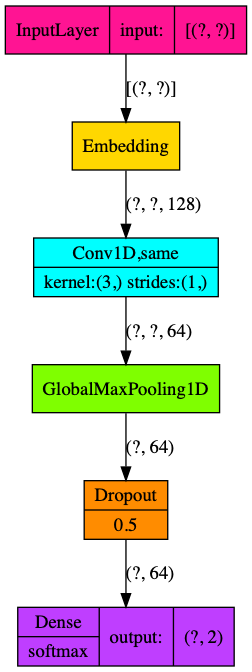

In [8]:
# 构建模型
model = Sequential()

# Embedding是一个权值矩阵，包含所有词汇的词向量，Embedding的行数等于词汇数，列数等于词向量长度
# Embedding的作用是获得每个词对应的词向量，这里的词向量是没有经过预训练的随机值，会跟随模型一起训练
# max_words词汇数，embedding_dims词向量长度
# 模型训练时数据输入为(batch, maxlen)
model.add(Embedding(max_words,
                    embedding_dims))

# 设置一个一维卷积
model.add(Conv1D(filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 activation='relu'))

# 卷积计算后得到的数据为(batch, maxlen, filters)
# GlobalMaxPooling1D-全局最大池化计算每一张特征图的最大值
# 池化后得到(batch, filters)
model.add(GlobalMaxPooling1D())
# 加上Dropout
model.add(Dropout(0.5))
# 最后2分类，设置2个神经元
model.add(Dense(2,activation='softmax'))
# 画图
plot_model(model)

In [9]:
# sparse_categorical_crossentropy和categorical_crossentropy都是交叉熵代价函数
# categorical_crossentropy需要把标签变成独热编码one-hot
# sparse_categorical_crossentropy不需要把标签变成独热编码one-hot(不是真的不需要，而且程序中会自动帮你做转换)
# 所以这个程序中的标签没有转独热编码one-hot
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 训练模型
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.4680 - accuracy: 0.7660 - val_loss: 0.3246 - val_accuracy: 0.8635
Epoch 2/3
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.2997 - accuracy: 0.8777 - val_loss: 0.2927 - val_accuracy: 0.8766
Epoch 3/3
25000/25000 [==============================] - 31s 1ms/sample - loss: 0.2161 - accuracy: 0.9168 - val_loss: 0.2991 - val_accuracy: 0.8772
